In [1]:
import getpass
import os

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain.chat_models import init_chat_model

from IPython.display import Image, display

from langchain_tavily import TavilySearch

import json

from langchain_core.messages import ToolMessage

from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

GOOGLE_API_KEY:  ········


In [4]:
_set_env("TAVILY_API_KEY")

In [5]:
class State(TypedDict):
    '''
        Messages are stored as lists.
        add_messages appends to the list here instead of overwriting them.
        check out add_messages annotation for more clarifications.
    '''
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [6]:
tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': "Introduction to LangGraph: A Beginner's Guide - Medium",
   'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
   'content': 'Stateful Graph: LangGraph revolves around the concept of a stateful graph, where each node in the graph represents a step in your computation, and the graph maintains a state that is passed around and updated as the computation progresses. LangGraph supports conditional edges, allowing you to dynamically determine the next node to execute based on the current state of the graph. We define nodes for classifying the input, handling greetings, and handling search queries. def classify_input_node(state): LangGraph is a versatile tool for building complex, stateful applications with LLMs. By understanding its core concepts and working through simple examples, beginners can start to leverage its powe

In [7]:
llm = init_chat_model("google_genai:gemini-2.0-flash")

llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [8]:
tool_node = ToolNode(tools)

In [9]:
graph_builder.add_node("tools", tool_node)

In [10]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

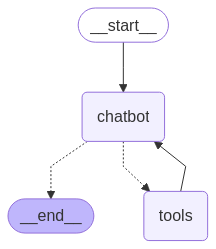

In [14]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q", "get out"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        user_input = "Why so shy bro?"
        print("Assistant: " + user_input)

User:  Hi! can you give a quick summary of Google Next 2025?


Assistant: I can't provide information about Google Next 2025 because it is in the future. If you'd like, I can provide information about the most recent Google Next event.


User:  can you tell me what date is it today?


Assistant: I do not have access to the current date. I can perform a search to try and answer your question. Would you like me to do that?


User:  yes please


Assistant: Okay, I'm ready. What can I help you search for?


User:  give me the latest news about ai?


Assistant: 
Assistant: {"query": "latest news about ai", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcrunch.com/2025/05/02/google-will-soon-start-letting-kids-under-13-use-its-gemini-chatbot/", "title": "Google will soon start letting kids under 13 use its Gemini chatbot - TechCrunch", "score": 0.6894943, "published_date": "Fri, 02 May 2025 20:13:07 GMT", "content": "AI More from TechCrunch Next week, Google will begin allowing kids under 13 who have parent-managed Google accounts to use its Gemini chatbot, according to The New York Times. A Google spokesperson told the publication that Gemini has specific guardrails for younger users, and that the company won’t use that data to train its AI. TechCrunch AI TechCrunch's AI experts cover the latest news in the fast-moving field. TechCrunch Space Startups are the core of TechCrunch, so get our best coverage delivered weekly. One of Google’s recent Gemini AI models scores worse on safety Goog

User:  q


Goodbye!
